#Mounting Google Drive locally and import necessary packages

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from glob import glob
import fnmatch
from google.colab import drive
drive.mount('/content/drive')
from keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras import regularizers
from keras.utils import conv_utils

from tensorflow.keras.models import *
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from keras.models import load_model, Model
from tensorflow.keras import regularizers
from keras.utils import conv_utils

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Kartik_BreakHis_aug/training/'
test_path = '/content/drive/MyDrive/Kartik_BreakHis_aug/test/'
val_path = '/content/drive/MyDrive/Kartik_BreakHis_aug/validation'
batch_size = 16
img_height = 224
img_width = 224
no_of_classes = 8
classes_name = [0,1,2,3,4,5,6,7]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)

Found 4561 images belonging to 8 classes.
Found 817 images belonging to 8 classes.
{'B-Adenosis': 0, 'B-Fibroadenoma': 1, 'B-Tubular_adenoma': 2, 'B-phyllodes_tumor': 3, 'M-Ductal_Carcinoma': 4, 'M-Lobular_Carcinoma': 5, 'M-mucinous-carcinoma': 6, 'M-papillary carcinoma': 7}


Model

In [ ]:
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model

import tensorflow as tf




def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])



def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y



def create_model():
    
    dropRate = 0.3
    
    init = Input((224,224,3))
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(8, activation='softmax')(x)
   
    model = Model(init, y)
    return model




model_breastnet = create_model()
model_breastnet.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model_breastnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

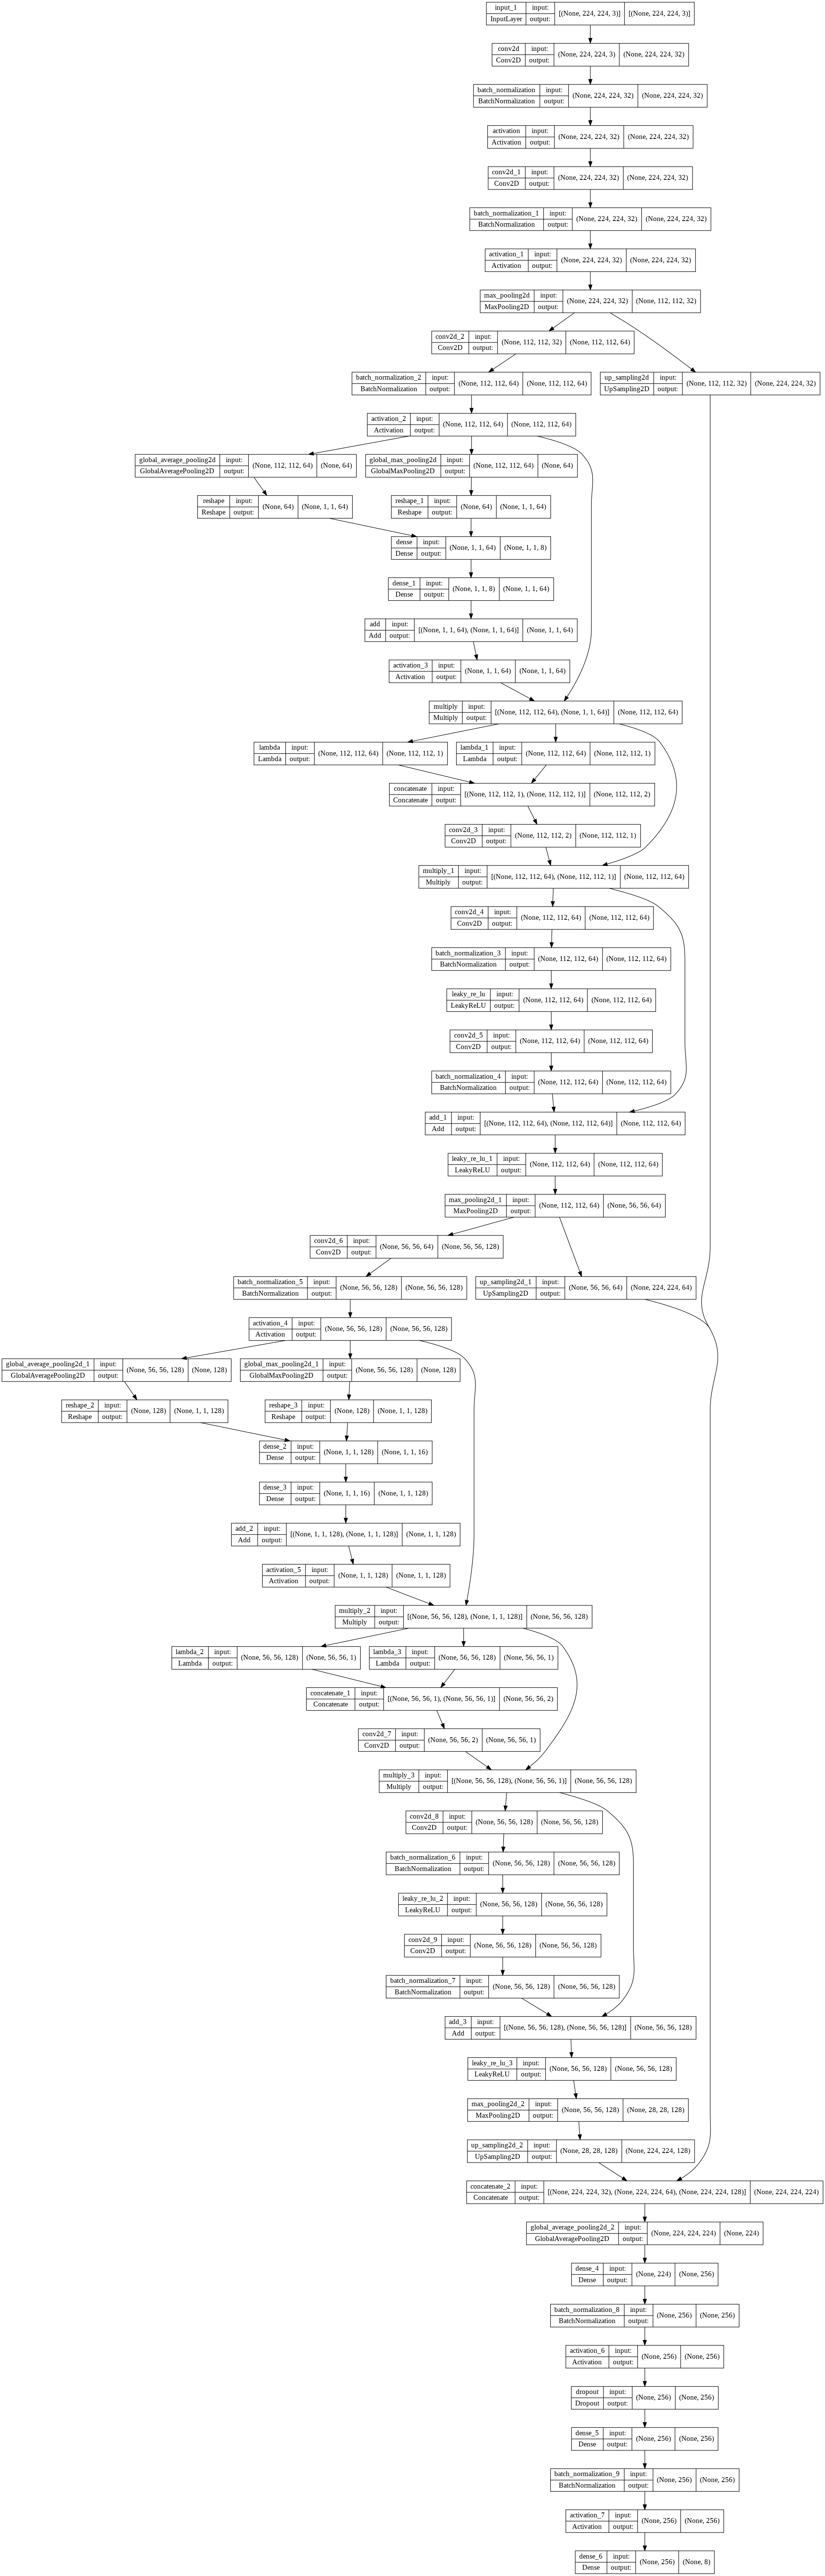

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_breastnet, to_file = '/content/drive/MyDrive/Kartik_BreakHis_aug/Blockdiagram_with_Channel_block.png', show_shapes = True, show_layer_names = True)

#Training

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)
check_path = '/content/drive/MyDrive/Kartik_BreakHis_aug/Weights_with_Channel_attention.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history_3A3 = model_breastnet.fit_generator(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 100,callbacks = [reduce_lr, early_stop, checkpoint] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
286/286 [==============================] - ETA: 0s - loss: 1.3750 - acc: 0.5058
Epoch 1: val_acc improved from -inf to 0.41126, saving model to /content/drive/MyDrive/Kartik_BreakHis_aug/Weights_with_Channel_attention.h5
286/286 [==============================] - 1573s 5s/step - loss: 1.3750 - acc: 0.5058 - val_loss: 2.2502 - val_acc: 0.4113 - lr: 0.0010
Epoch 2/100
286/286 [==============================] - ETA: 0s - loss: 1.0636 - acc: 0.6135
Epoch 2: val_acc improved from 0.41126 to 0.45410, saving model to /content/drive/MyDrive/Kartik_BreakHis_aug/Weights_with_Channel_attention.h5
286/286 [==============================] - 89s 311ms/step - loss: 1.0636 - acc: 0.6135 - val_loss: 2.3927 - val_acc: 0.4541 - lr: 0.0010
Epoch 3/100
286/286 [==============================] - ETA: 0s - loss: 0.9214 - acc: 0.6564
Epoch 3: val_acc did not improve from 0.45410
286/286 [==============================] - 82s 285ms/step - loss: 0.9214 - acc: 0.6564 - val_loss: 3.5982 - val_acc: 0.1

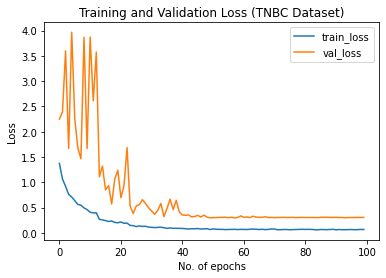

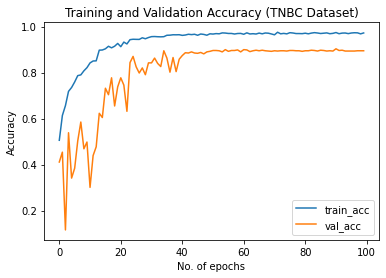

In [ ]:
plt.plot(history_3A3.history['loss'] , label = 'train_loss')
plt.plot(history_3A3.history['val_loss'] , label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (TNBC Dataset)")
plt.savefig("/content/drive/MyDrive/Kartik_BreakHis_aug/Channel+s_attention_Loss_Plot22.jpg")
plt.show()

plt.plot(history_3A3.history['acc'] , label = 'train_acc')
plt.plot(history_3A3.history['val_acc'] , label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy (TNBC Dataset)")
plt.savefig("/content/drive/MyDrive/Kartik_BreakHis_aug/Channel_attention+s_Acc_Plot22.jpg")
plt.show()

In [ ]:
model_breastnet.load_weights('/content/drive/MyDrive/Kartik_BreakHis_aug/Weights_with_Channel_attention.h5')

Results and plots

Found 646 images belonging to 8 classes.
original
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


646/646 [==============================] - 131s 200ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 7 7 7 2 2 2 3 3 3 3
 3 3 1 3 1 3 3 1 6 6 6 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2
 2 4 4 4 4 4 4 2 1 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 5 5 4 7 7 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

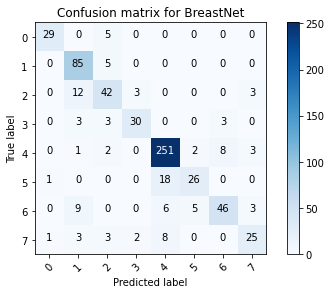

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=1,
    shuffle = False,
    class_mode='categorical')
print('original')
print(test_generator.labels)
print('\n')
print('predicted')
test_step = test_generator.n//test_generator.batch_size
test_generator.reset()
pred = model_breastnet.predict_generator(test_generator , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)
print(pred_class_indices)
print('\n')

print(train_generator.class_indices)
print('\n')
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score,jaccard_score,classification_report
print('Precision {}'.format(precision_score(y_true=test_generator.labels, y_pred=pred_class_indices,average = 'macro')))
print('Recall {}'.format(recall_score(y_true=test_generator.labels, y_pred=pred_class_indices,average='macro')))
print('Accuracy {}'.format(accuracy_score(y_true=test_generator.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test_generator.labels, y_pred=pred_class_indices,average = 'macro')))
print('jaccard {}'.format(jaccard_score(y_true=test_generator.labels, y_pred=pred_class_indices,average = 'macro')))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test_generator.labels, y_pred=pred_class_indices)))
#print('classification_report\n {}'.format(classification_report(y_true=test_generator.labels, y_pred=pred_class_indices)))
print('\n\n')

met = np.zeros((no_of_classes+1,5))

avg_met = [precision_score(y_true=test_generator.labels, y_pred=pred_class_indices,average = 'macro'),
           recall_score(y_true=test_generator.labels, y_pred=pred_class_indices,average='macro'),
           f1_score(y_true=test_generator.labels, y_pred=pred_class_indices,average = 'macro'),
           jaccard_score(y_true=test_generator.labels, y_pred=pred_class_indices,average = 'macro'),
           accuracy_score(y_true=test_generator.labels, y_pred=pred_class_indices)]

avg_met = np.array(avg_met)
avg_met.round(decimals=2)
met[no_of_classes,:] = avg_met

classes = classes_name


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test_generator.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")

    class_met = [precision_score(y_true=a1, y_pred=a2),
                 recall_score(y_true=a1, y_pred=a2),
                 f1_score(y_true=a1, y_pred=a2),
                 jaccard_score(y_true=a1, y_pred=a2),
                 accuracy_score(y_true=a1, y_pred=a2)]

    class_met = np.array(class_met)
    class_met.round(decimals=2)
    met[cl,:] =class_met


print(met)
# np.save('/content/drive/My Drive/Major_project_data/Kidney_TGCA/TGCA_kidney_dataset_aug_2/Metrics/breastnet_kidney_tgca_met_3.npy',met)

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true=test_generator.labels, y_pred=pred_class_indices)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, classes_name,
                        normalize=False,
                        title='Confusion matrix for BreastNet',
                        cmap=plt.cm.Blues)

